# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Описание данных

Данные лежат в файле /datasets/taxi.csv.

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# Библиотеки

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
# inport knnregreesor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
%pip install -q catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
from catboost import CatBoostRegressor

In [4]:
%pip install -q --no-binary lightgbm --config-settings=cmake.define.USE_OPENMP=OFF 'lightgbm>=4.0.0'
import lightgbm as lgb
from lightgbm import LGBMRegressor


Usage:   
  /opt/conda/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] [-e] <vcs project url> ...
  /opt/conda/bin/python -m pip install [options] [-e] <local project path> ...
  /opt/conda/bin/python -m pip install [options] <archive url/path> ...

no such option: --config-settings
Note: you may need to restart the kernel to use updated packages.


# Функции

In [5]:
def hist_underbox_detailed(data,title=None, left_p=0.05, right_p=0.95):
    custom_params = {"axes.spines.right": False, "axes.spines.top": False};
    sns.set_theme(style="darkgrid", rc=custom_params);
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(x=data, ax=ax_box).set_title(title)
    sns.histplot(x=data, ax=ax_hist, kde=True)
    ax_box.set(yticks=[])
    ax_box.set_xlabel("")
    ax_hist.set_ylabel("Количество")
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    mean = ax_hist.axvline(data.mean(), color='r',ls='--', lw=2)
    median = ax_hist.axvline(data.median(), color='k', ls='--', lw=2)
    q = ax_hist.axvline(data.quantile(left_p), color='b',ls='--', lw=2)
    qqq = ax_hist.axvline(data.quantile(0.95), color='g',ls='--', lw=2)
    ax_hist.legend([mean, median,q,qqq], [f'Среднее значение = {round(data.mean(),2)}',
                                    f'Медиана = {round(data.median(),2)}',
                                    f'{left_p*100}-й перцентиль = {round(data.quantile(left_p),2)}',
                                    f'{right_p*100}-й перцентиль = {round(data.quantile(right_p),2)}'],
                                    bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Загрузка данных

In [6]:
pth1 = '/datasets/taxi.csv'
pth2 = 'taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')


if os.path.exists(pth1):
    f = pd.read_csv(pth1, parse_dates=[0])
elif os.path.exists(pth2):
    f = pd.read_csv(pth2, parse_dates=[0])
else:
    print('Something is wrong')

In [7]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
df.sort_index(inplace=True)
print(df.index.is_monotonic_increasing)
print(df.info())

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


# Вывод

Данные в порядке.

# Исследовательский анализ данных

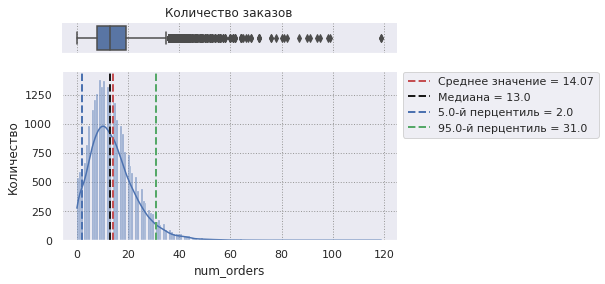

In [9]:
hist_underbox_detailed(f['num_orders'],title='Количество заказов')

In [10]:
f.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<Figure size 432x288 with 0 Axes>

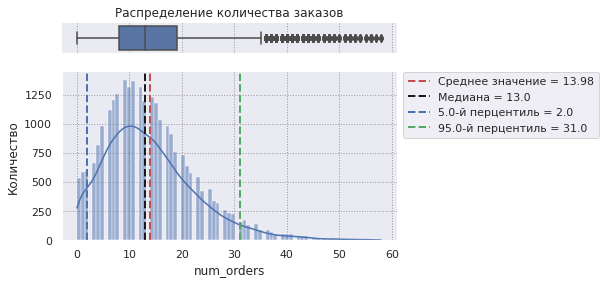

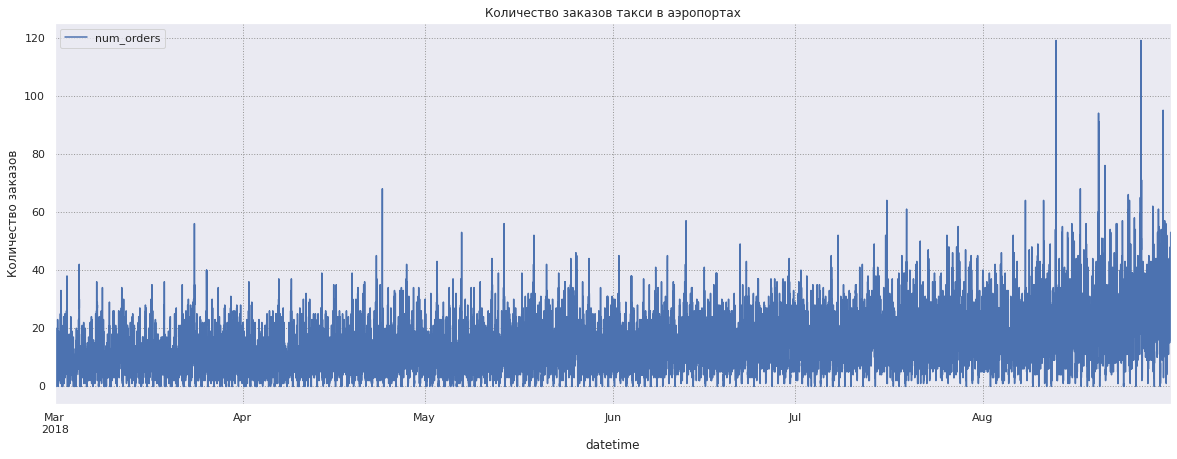

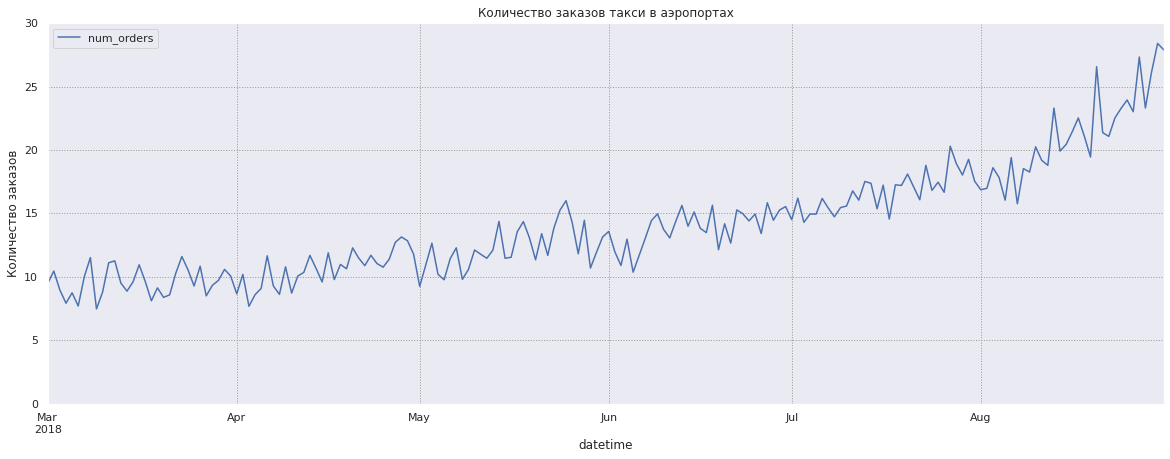

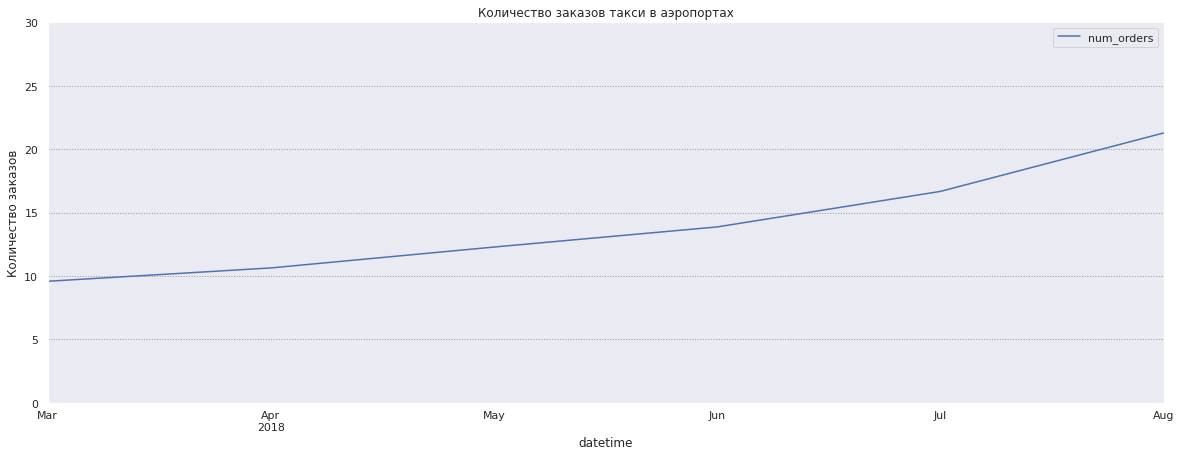

In [11]:
plt.figure(0)
hist_underbox_detailed(f.loc[f['num_orders']<60,'num_orders'],title='Распределение количества заказов');
plt.figure(1)
df.plot(figsize=(20,7));
plt.ylabel('Количество заказов');
plt.title('Количество заказов такси в аэропортах');
plt.figure(2)
df.resample('1D').mean().plot(figsize=(20,7),ylim=(0,30));
plt.ylabel('Количество заказов');
plt.title('Количество заказов такси в аэропортах');
plt.figure(3)
df.resample('1M').mean().plot(figsize=(20,7),ylim=(0,30));
plt.ylabel('Количество заказов');
plt.title('Количество заказов такси в аэропортах');
plt.show()

In [12]:
tample = df.resample('1D').mean()
tample['mean'] = tample['num_orders'].rolling(15,closed='left').mean()
tample['mean_plus_std'] = tample['mean'] + tample['num_orders'].rolling(15,closed='left').std()
tample['mean_minus_std'] = tample['mean'] - tample['num_orders'].rolling(15,closed='left').std()

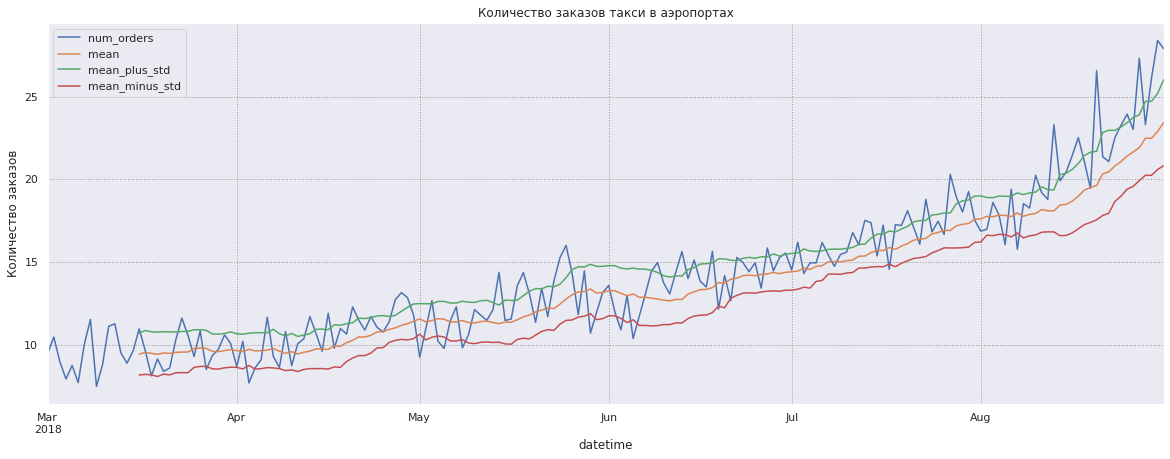

In [13]:
tample[['num_orders','mean','mean_plus_std','mean_minus_std']].plot(figsize=(20,7));
plt.ylabel('Количество заказов');
plt.title('Количество заказов такси в аэропортах');
plt.show()

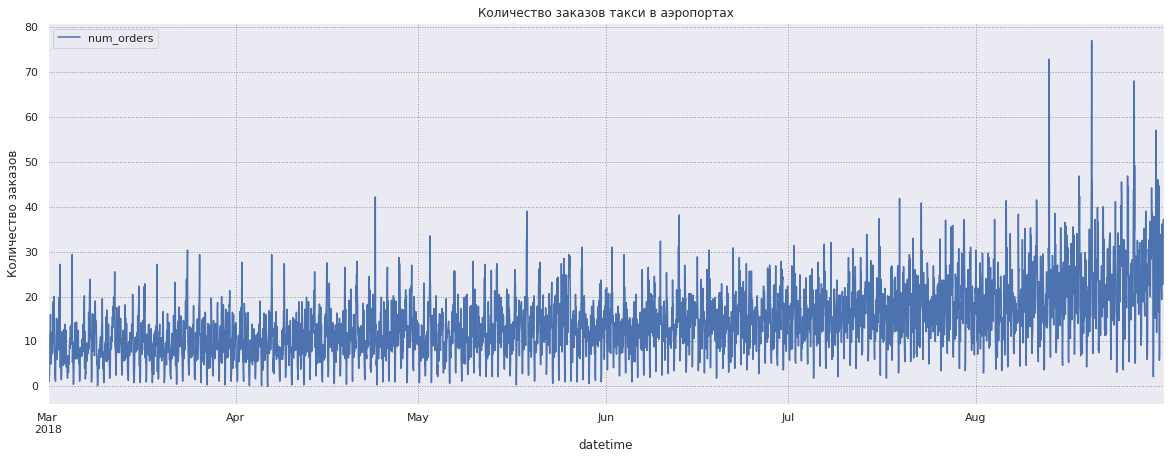

In [14]:
df.resample('1H').mean().plot(figsize=(20,7));
plt.ylabel('Количество заказов');
plt.title('Количество заказов такси в аэропортах');
plt.show()

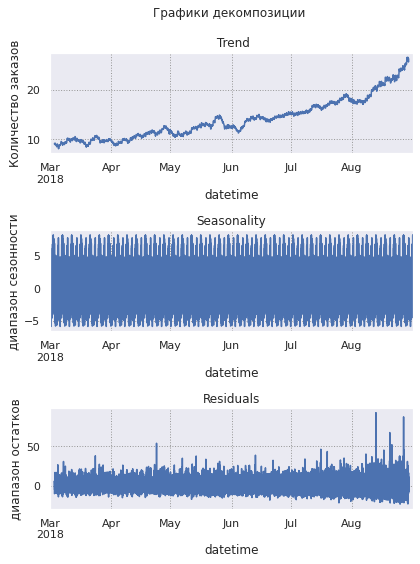

In [15]:
decomposed = seasonal_decompose(df,period=24*28)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Количество заказов');
plt.title('Графики декомпозиции \n\n Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('диапазон сезонности');
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('диапазон остатков');
plt.tight_layout()

Явно наблюдается тренд на увеличение среднего числа заказов такси в еденицу времени с марта по август.

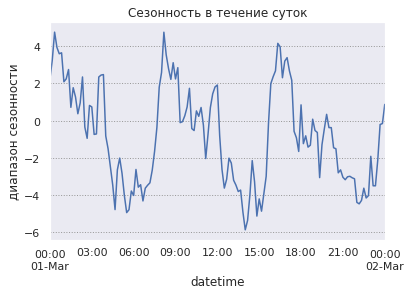

In [16]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'].plot();
plt.title('Сезонность в течение суток');
plt.ylabel('диапазон сезонности');


Наблюдаем сезонность в течение суток – с периодом ≈ 7 часов. Максимум примерно в 9 утра, минимум примерно в обед, потом снова максимум примерно в 16:30, минимум в 22:30, максимум в час ночи и т.д.

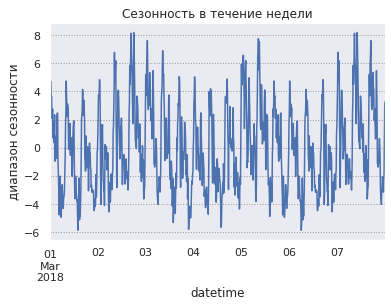

In [17]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();
plt.title('Сезонность в течение недели');
plt.ylabel('диапазон сезонности');


На масштабе в 7 дней тоже видим сезонность – с периодом ≈ в 2÷3 суток.

## Вывод

- Визуализировали временной ряд, ознакомились с его статистикой;
- Имеющийся временной ряд является нестационарным, так как его среднее значение и стандартное отклонение меняются со временем, что легко видно из графиков;
- Явно наблюдается тренд на увеличение среднего числа заказов такси в еденицу времени с марта по август;
- Наблюдаем сезонность в течение суток – с периодом ≈ 7 часов. Максимум примерно в 9 утра, минимум примерно в обед, потом снова максимум примерно в 16:30, минимум в 22:30, максимум в час ночи и т.д. На масштабе в 7 дней тоже видим сезонность – с периодом ≈ в 2÷3 суток. Это, скорее всего, связано с особенностями работы такси, а также с расписаниями рейсов – увеличение спроса в течение суток обусловлено прилётами новых самолётов, а в час ночи – такси это единственный способ уехать из аэропорта. На масштабе в 7 дней увеличение спроса может быть обусловленно, например, периодичными прибытиями пассажиров в весенние или летние отпуска.

# Модель

Сделаем ресмплирование по одному часу:

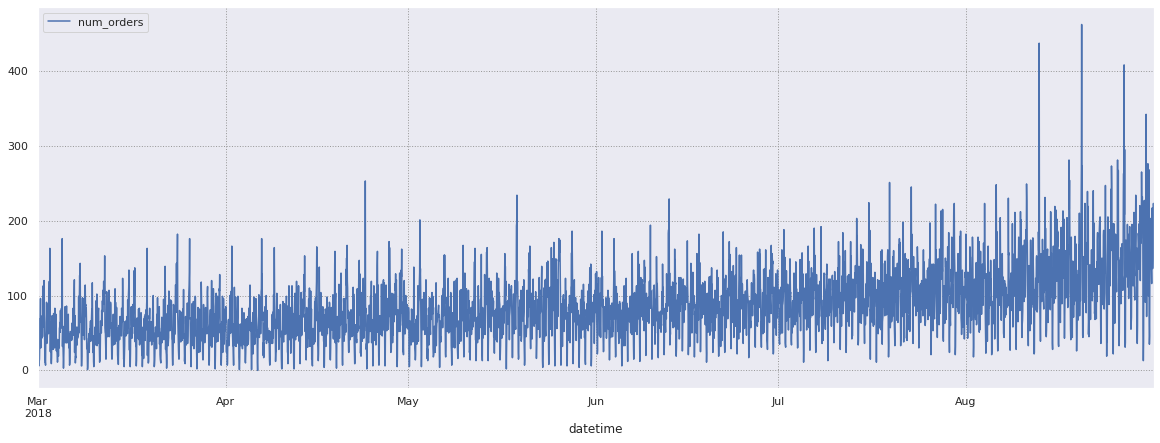

In [18]:
df_h = df.copy().resample('1H').sum()
df_h.sort_index(inplace=True)
df_h.plot(figsize=(20,7));

In [19]:
train, test = train_test_split(df_h, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Оценим константным прогнозом через медиану:

In [20]:
print("Среднее количество заказов в час:", round(test['num_orders'].mean(),2))

pred_median = np.ones(test.shape) * train['num_orders'].median()

rmse = mean_squared_error(test['num_orders'], pred_median, squared=False)

print("test RMSE:", round(rmse,2))

Среднее количество заказов в час: 139.56
test RMSE: 87.15


Оценим предыдущим значением ряда:

In [21]:
print("Среднее количество заказов в час:", round(test['num_orders'].mean(),2))

pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse = mean_squared_error(test['num_orders'], pred_previous, squared=False)
print("test RMSE:", round(rmse,2))

Среднее количество заказов в час: 139.56
test RMSE: 58.86


Создадим признаки для горизонта прогнозирования в один шаг. Для этого напишем следующую функцию:


In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return data

Напишем функцию, которая на вход будет принимать еще и модель, возвращая RMSE:

In [23]:
def learn(model,data, max_lag, rolling_mean_size):
    data = make_features(data, max_lag, rolling_mean_size)

    train, valid_test = train_test_split(data, shuffle=False, test_size=0.2)
    train = train.dropna()
    valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

    X_train = train.drop(['num_orders'], axis=1)
    y_train = train['num_orders']
    X_valid = valid.drop(['num_orders'], axis=1)
    y_valid = valid['num_orders']

    student = model.fit(X_train, y_train)
    y_pred = student.predict(X_valid)
    rmse_valid = mean_squared_error(y_valid, y_pred, squared=False)

    return rmse_valid

Таблица с результатами разных моделей с разными гиперпараметрами:

In [24]:
compare_table = pd.DataFrame({
    'model':['LinearRegression()',
             'KNeighborsRegressor(n_neighbors=2)',
             'KNeighborsRegressor(n_neighbors=5)',
             'KNeighborsRegressor(n_neighbors=7)',
             'CatBoostRegressor(learning_rate=0.05)',
             'CatBoostRegressor(learning_rate=0.3)',
             'CatBoostRegressor(learning_rate=0.8)',
             'LGBMRegressor(learning_rate=0.05)',
             'LGBMRegressor(boosting_type=`goss`,learning_rate=0.05)',
             'LGBMRegressor(learning_rate=0.2)',
             'LGBMRegressor(boosting_type=`goss`,learning_rate=0.2)'],
    'rmse_valid': [learn(LinearRegression(),df_h,80,80),
                   learn(KNeighborsRegressor(n_neighbors=2),df_h,80,80),
                   learn(KNeighborsRegressor(n_neighbors=5),df_h,80,80),
                   learn(KNeighborsRegressor(n_neighbors=7),df_h,80,80),
                   learn(CatBoostRegressor(learning_rate=0.05,random_state=42),df_h,80,80),
                   learn(CatBoostRegressor(learning_rate=0.3,random_state=42),df_h,80,80),
                   learn(CatBoostRegressor(learning_rate=0.8,random_state=42),df_h,80,80),
                   learn(LGBMRegressor(learning_rate=0.05,random_state=42),df_h,80,80),
                   learn(LGBMRegressor(boosting_type='goss',learning_rate=0.05,random_state=42),df_h,80,80),
                   learn(LGBMRegressor(learning_rate=0.2,random_state=42),df_h,80,80),
                   learn(LGBMRegressor(boosting_type='goss',learning_rate=0.2,random_state=42),df_h,80,80)],
})

0:	learn: 34.8354685	total: 77.9ms	remaining: 1m 17s
1:	learn: 34.0711235	total: 92.9ms	remaining: 46.4s
2:	learn: 33.2927891	total: 108ms	remaining: 36s
3:	learn: 32.5293397	total: 124ms	remaining: 30.8s
4:	learn: 31.8848205	total: 139ms	remaining: 27.6s
5:	learn: 31.2767167	total: 159ms	remaining: 26.4s
6:	learn: 30.6809312	total: 175ms	remaining: 24.8s
7:	learn: 30.1018028	total: 191ms	remaining: 23.7s
8:	learn: 29.6010364	total: 206ms	remaining: 22.7s
9:	learn: 29.0770961	total: 221ms	remaining: 21.9s
10:	learn: 28.6288557	total: 237ms	remaining: 21.3s
11:	learn: 28.1687125	total: 257ms	remaining: 21.1s
12:	learn: 27.7615157	total: 272ms	remaining: 20.7s
13:	learn: 27.3536767	total: 288ms	remaining: 20.3s
14:	learn: 26.9814225	total: 303ms	remaining: 19.9s
15:	learn: 26.6095783	total: 317ms	remaining: 19.5s
16:	learn: 26.2896885	total: 332ms	remaining: 19.2s
17:	learn: 25.9704771	total: 351ms	remaining: 19.2s
18:	learn: 25.6708015	total: 368ms	remaining: 19s
19:	learn: 25.3984543	t

In [25]:
# gigacode, напиши в pd.set_option такое условие, чтобы текст в значениях столбца таблицы выводился полностью
pd.set_option('display.max_colwidth',None)

compare_table.sort_values(by='rmse_valid', ascending=True).round(3)

,model,rmse_valid
4,CatBoostRegressor(learning_rate=0.05),30.205
0,LinearRegression(),30.615
7,LGBMRegressor(learning_rate=0.05),30.656
8,"LGBMRegressor(boosting_type=`goss`,learning_rate=0.05)",30.829
9,LGBMRegressor(learning_rate=0.2),31.428
5,CatBoostRegressor(learning_rate=0.3),31.719
3,KNeighborsRegressor(n_neighbors=7),31.819
2,KNeighborsRegressor(n_neighbors=5),31.941
10,"LGBMRegressor(boosting_type=`goss`,learning_rate=0.2)",32.166
1,KNeighborsRegressor(n_neighbors=2),32.927


Видим, что по метрике RMSE на валидационной выборке лидер – модель `CatBoostRegressor` с гиперпараметром `learning_rate=0.05`, а так же в ТОП-3 вошла линейная регрессия и `LGBMRegressor` с гиперпараметрами `boosting_type='gbdt'` (по умолчанию) и `learning_rate=0.05`.

Посмотрим чему равна метрика лучшей модели на тестовой выборке:

In [26]:
data = make_features(df_h, 80, 80)

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

student = CatBoostRegressor(learning_rate=0.05).fit(X_train, y_train)

0:	learn: 37.6690737	total: 26.5ms	remaining: 26.5s
1:	learn: 36.7992691	total: 43.7ms	remaining: 21.8s
2:	learn: 35.9662466	total: 60.6ms	remaining: 20.1s
3:	learn: 35.1480979	total: 81ms	remaining: 20.2s
4:	learn: 34.4479294	total: 100ms	remaining: 19.9s
5:	learn: 33.7469845	total: 118ms	remaining: 19.5s
6:	learn: 33.1324167	total: 135ms	remaining: 19.2s
7:	learn: 32.4840155	total: 153ms	remaining: 19s
8:	learn: 31.9514330	total: 172ms	remaining: 18.9s
9:	learn: 31.3821873	total: 193ms	remaining: 19.1s
10:	learn: 30.8049946	total: 210ms	remaining: 18.9s
11:	learn: 30.3420943	total: 227ms	remaining: 18.7s
12:	learn: 29.8649567	total: 244ms	remaining: 18.5s
13:	learn: 29.3935840	total: 261ms	remaining: 18.4s
14:	learn: 28.9594405	total: 284ms	remaining: 18.6s
15:	learn: 28.5810439	total: 302ms	remaining: 18.6s
16:	learn: 28.2070672	total: 320ms	remaining: 18.5s
17:	learn: 27.8352778	total: 337ms	remaining: 18.4s
18:	learn: 27.5042726	total: 356ms	remaining: 18.4s
19:	learn: 27.1990832	

In [27]:
y_pred = student.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)

In [28]:
print("test RMSE:", round(test_rmse,2))

test RMSE: 38.27


Видим, что и на тестовой выборке лучшая модель удовлетворяет требованию заказчика (RMSE < 48)

## Вывод

- Наилучшей моделью для прогнозирования временного ряда оказалась `CatBoostRegressor` с гиперпараметром `learning_rate` равным `0.05`.

# Вывод

- Визуализировали временной ряд, ознакомились с его статистикой;
- Имеющийся временной ряд является нестационарным, так как его среднее значение и стандартное отклонение меняются со временем, что легко видно из графиков;
- Явно наблюдается тренд на увеличение среднего числа заказов такси в еденицу времени с марта по август;
- Наблюдаем сезонность в течение суток – с периодом ≈ 7 часов. Максимум примерно в 9 утра, минимум примерно в обед, потом снова максимум примерно в 16:30, минимум в 22:30, максимум в час ночи и т.д.;
- На масштабе в 7 дней тоже видим сезонность – с периодом ≈ в 2÷3 суток.

- Обучили 9 моделей
- Наилучшей моделью для прогнозирования временного ряда оказалась `CatBoostRegressor` с гиперпараметром `learning_rate` равным `0.05`. На тестовой выборке лучшая модель удовлетворяет требованию заказчика (RMSE < 48)